<a href="https://colab.research.google.com/github/DerekGloudemans/segmentation-medical-images/blob/master/2D_Seg_Evaluation_and_Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets

     |████████████████████████████████| 112kB 2.9MB/s 


In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



In [0]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=1,
        depth=3,
        wf=4,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        innum = 1000
        midnum = 100
        outnum = 4*n_classes
        self.reg = nn.Sequential(
            nn.BatchNorm1d(innum),
            nn.Linear(innum,midnum),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(midnum,outnum),
            nn.Sigmoid()
        )

        #for param in self.parameters():
        #  param.requires_grad = True

    def forward(self, x,BBOX = False):
        blocks = []
        
        # encoder
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        # do bbox regression here
        if BBOX:
          x_reg = x.view(-1)
          x_reg = self.reg(x_reg)
          bboxes = x_reg.view(4,-1)

        # decoder
        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        #CHANGE THIS LINE FOR MULTIPLE OUTPUT CHANNELS
        # apply per_class last layer and per-class Softmax 
        #x = nn.Softmax2d(self.last(x)) 
        x = torch.sigmoid(self.last(x))
        
        if BBOX:
          return x, bboxes
        else:
          return x


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Define Dataset for Dealing with NIfTI Files
(1) spleen
(2) right kidney
(3) left kidney
(4) gallbladder
(5) esophagus
(6) liver
(7) stomach
(8) aorta
(9) inferior vena cava
(10) portal vein and splenic vein
(11) pancreas
(12) right adrenal gland
(13) left adrenal gland

In [0]:
class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "view",dim = 2,class_id = 1):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - view,train or val, defined in same dataset to maintain data separation
      view - performs transforms but does not normalize images
      train - normalizes data and performs transforms
      val - normalizes data, no augmenting transforms
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim
    self.class_id = class_id

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_fdata()).astype(float)

      identifier = self.data_files[i].split("_")[0]
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        mean,std = np.mean(data_slice),np.std(data_slice)
        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice,
            "mean":mean,
            "std":std
            }

        # check to make sure this example actually has organs in it
        test = np.bincount(label_slice.astype(int).reshape(-1))
        if len(test) == 1: 
          continue

        # make sure 50% of examples have organ of interest in them
        if class_id not in np.unique(label_slice.astype(int).reshape(-1)):
            if np.random.rand() > 0.5:
              continue

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      #break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.0015, scale=(0.4, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.003, scale=(0.1, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.004, scale=(0.05, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.0035, scale=(0.05, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode in ['train','view']:
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode in ['train','view']:
        # randomly flip and rotate both
        FLIP = 0 #np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = 0 #np.random.rand()*60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE,Image.NEAREST)

      # resize to 224 on shorter dimension
      x = FT.resize(x, 256)
      y = FT.resize(y,256,Image.NEAREST)

      if self.mode in ['train','view']:
        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)
      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)
            
      # normalize and repeat along color dimension if in train or val mode
      if self.mode in ['train','val']:
        #x = FT.normalize(x,[item['mean']],[item['std']])
        #x = x.repeat(3,1,1)
        pass

      return x,y

  def __len__(self):
    if self.mode in ["train","view"]:
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    data = data.detach()
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

  def show_slices(self,idx = 0,dim = 0,organ_id = None):
    """
    A nice utility function for plotting all of the slices along a given dimension
    idx - indexes all NIfTI images in dataset
    dim - indexes dimension of image
    organ_id - if not None, all other organs removed from label
    """
    data = nib.load(self.data_files[idx])
    label = nib.load(self.label_files[idx])

    data = data.get_fdata()
    data = np.array(data)
    label = label.get_fdata()
    label = np.array(label)

    for slice in range(0,data.shape[dim]):
      if dim == 0:
            data_slice = data[slice,:,:]
            label_slice = label[slice,:,:]
      elif dim == 1:
        data_slice = data[:,slice,:]
        label_slice = label[:,slice,:]
      elif dim == 2:
        data_slice = data[:,:,slice]
        label_slice = label[:,:,slice]

      if organ_id is not None:
        # if a specific label is to be looked at, 0 all others
        label_slice = 1.0 - np.ceil(np.abs(label_slice.astype(float)-organ_id)/15.0)

      print(np.unique(label_slice))
      plt.figure()
      plt.subplot(121)
      plt.imshow(data_slice,cmap = "gray")

      plt.subplot(122)
      plt.imshow(label_slice,cmap = "gray")
      plt.show()

  def len_3d(self):
    return len(self.data_files)

  def get_3d_array(self,idx):
      """
      Loads a 3D image as a tensor as well as its label, mode, and file name
      """
      assert idx < len(self.data_files) , "3D image index out of range, there are {} 3D images".format(len(self.data_files))

      # load data and label as tensors
      data = nib.load(self.data_files[idx])
      label = nib.load(self.label_files[idx])

      data = data.get_fdata()
      data = torch.from_numpy(np.array(data))
      label = label.get_fdata()
      label = torch.from_numpy(np.array(label)).int()

      # note whether image is training or validation set
      if idx < 0.85 * len(self.data_files):
        mode = "train"
      else:
        mode = "val"
      
      return data,label,mode,self.data_files[idx]


In [0]:
def refactor_inputs(x,y,mode = "all_organs",id_num = 1,num_outputs = 1):
  """
  Modifies inputs for different segmentation-style tasks with the goal of training
  the same network for progressively more difficult tasks
  mode - foreground,all_organs,edges,organ_slices, bboxes 
  x - batch x 1 x 256x256 image
  y - batch x 1 x 256 x 256 image with integer value classes
  id_num - int - specifies organ to look for for single organ mode
  num_outputs - specifies number of output maps to make
  """
  ones = torch.ones(y.shape)
  zeros = torch.zeros(y.shape)
  y = (y/0.0039).floor().int()

  if mode == "foreground":
    # all foreground is 1, everything else is 0
    # all slices but first share same info
    threshold = x.mean()
    y1 = torch.where(x > threshold,ones,zeros)
    # fills all labeled areas with ones as well
    y1 = torch.where(y>0,ones,y1)
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "all_organs":
    # all organs are one, everything else is 0
    positive_class = 0
    y1 = torch.where(y > 0,ones, zeros)
    # get same map for each class
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "single_organ":
    # all slices contain same map (positive for a single organ)
    y1 = torch.where((y == id_num),ones,zeros)
    target = y1#.repeat(1,num_outputs,1,1)

  elif mode == "edges":
    pooled = F.avg_pool2d(y,3,stride =1,padding = 1 )
    y1 = torch.abs(pooled - y)
    y1 = torch.where(y1>0,ones,zeros)
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "x_edges":
    x_norm = torch.where(x>0,ones,zeros)
    pooled = F.avg_pool2d(x_norm,3,stride =1,padding = 1 )
    y1 = torch.abs(pooled - x_norm)
    y1 = torch.where(y1>0.1,ones,zeros)
    target = y1.repeat(1,num_outputs,1,1)

  elif mode == "bboxes":

    indices = y.nonzero()
    target = torch.zeros((y.shape[0],13,4)) # batch idx, class idx, xmin ymin xmax ymax
    target[:,:,:2] = 100000 # set min to greater than 
    for item in indices:
      batch_idx = item[0]
      x_val = item[3]
      y_val = item[2]
      class_idx = int(y[batch_idx,0,y_val,x_val]) -1

      if x_val < target[batch_idx,class_idx,0]:
        target[batch_idx,class_idx,0] = x_val
      if x_val > target[batch_idx,class_idx,2]:
        target[batch_idx,class_idx,2] = x_val
      if y_val < target[batch_idx,class_idx,1]:
        target[batch_idx,class_idx,1] = y_val
      if y_val > target[batch_idx,class_idx,3]:
        target[batch_idx,class_idx,3] = y_val  

  elif mode == "all_to_one":
    # all slices contain same map (positive for a single organ)
    y1 = torch.where((y.int() == id_num),ones,zeros)
    target = y1#.repeat(1,num_outputs,1,1)
     
    positive_class = 0
    x1 = torch.where(y > 0,ones, zeros)
    # get same map for each class
    x = x1.repeat(1,num_outputs,1,1)

  return x,target

def test_slice(dataset,model,idx,device,refactor_mode,id_num = 1):
  x,y = dataset[idx]
  x = x.unsqueeze(0)
  y = y.unsqueeze(0)

  x,y_new = refactor_inputs(x,y,mode = refactor_mode,id_num = id_num)
  x = x.to(device)

  output = model(x)
  output = output.cpu()
  output = output.data.numpy()
  
  # inputs
  plt.figure(figsize = (10,10))
  plt.subplot(221)
  plt.title("Inputs")
  inputs = x.data.cpu().numpy()[0][0]
  plt.imshow(inputs,cmap = "gray")
  plt.clim(0,1)

  # original labels
  plt.subplot(222)
  plt.imshow(y[0][0],cmap = "gray")
  plt.title("Original Labels")


  # outputs
  plt.subplot(223)
  plt.imshow(output[0][0],cmap = "gray")
  plt.clim(0,1)
  plt.title("Outputs")
 
  # binary target
  if refactor_mode == "bboxes":
    # binary target
    plt.subplot(224)
    copy = y[0][0].data.numpy().copy()
    for box in y_new[0]:
      if box[0] < 10000:
        corner1 = (box[0],box[1])
        corner2 = ((box[2],(box[3])))
        copy = cv2.rectangle(copy,corner1,corner2,(0.1),1)
      #break

    plt.imshow(copy,cmap = "gray")
    plt.title("Correct Labels")
    #plt.clim(0,13)
    plt.show()

  else:
    plt.subplot(224)
    plt.imshow(y_new[0][0],cmap = "gray")
    plt.title("Correct Labels")
    #plt.clim(0,1)
    plt.show()

  return inputs, output[0][0]

class Dice_Loss(nn.Module):        
    def __init__(self):
        super(Dice_Loss,self).__init__()
        
    def forward(self,output,target,epsilon = 1e-07):
        """ Compute the bbox iou loss for target vs output using tensors to preserve
        gradients for efficient backpropogation"""

        numerator = 2.0*torch.mul(output,target) 
        denominator = output + target
        dice = torch.div(numerator,denominator)
        #print (dice.shape)
        #loss =  1.0 -(torch.sum(dice)/torch.numel(dice))
        #print("{} / {} = {}".format(numerator.sum(),denominator.sum(),loss))

        loss = 1.0 - torch.sum(numerator)/torch.sum(denominator)
        #print (loss.shape)
        #print (loss)
        return loss

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

  return model,optimizer,epoch,all_losses,all_accs

## Define Assorted Functions for Training and Testing

Critical to realize here is that we can either define a UNet that has 1 output channel (positive negative) or 13 output channels (each class). For now, we'll start with just one output map, and see where that gets us

## Main Code Body


In [0]:
checkpoint_dict = {
    0:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ0_e7.pt",
    1:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ1_e120.pt",
    2:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ2_e119.pt",
    3:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ3_e14.pt",
    4:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ4_e2.pt",
    5:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ5_e26.pt",
    6:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ6_e45.pt",
    7:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ7_e2.pt",
    8:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ8_e26.pt",
    9:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ9_e37.pt",
    10:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ10_e80.pt",
    11:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ11_e33.pt",
    12:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ12_e46.pt",
    13:"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/best_UNET11_organ13_e34.pt"

}


In [0]:
  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  torch.cuda.empty_cache()   
  
  model = UNet()
  print ("Model loaded.")
  model = model.to(device)
  model.eval()

  checkpoint = torch.load(checkpoint_dict[6])
  model.load_state_dict(checkpoint['model_state_dict'])


Model loaded.


<All keys matched successfully>

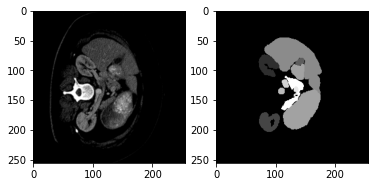

NameError: ignored

In [0]:
try:
  dataset
except:
  dataset = Nifti_Dataset(mode = "train",dim = 2)

idx = np.random.randint(0,len(dataset))
dataset.show(idx)

x,y,mode,name = dataset.get_3d_array(0)
result = predict_by_slices(model,x,device)

In [0]:
if False:
  count = 0
  per_class_total = torch.zeros(14)
  total = 0

  for i in range(0,dataset.len_3d()):
    x,y,mode,name = dataset.get_3d_array(i)
    
    if mode == "val":
      break
    result = segment(model,checkpoint_dict,x,device)

    per_class,overall = Dice_3D(result,y)
    print("Finished volume {}. Avg. Dice {} ".format(i,overall))

    count = count+1
    per_class_total += per_class
    total += overall

  per_class_total = per_class_total / count
  total = total / count

  print ("Classwise dice accuracies: {}".format(per_class_total))


In [0]:
if False:
  checkpoint = torch.load(checkpoint_dict[1])
  model.load_state_dict(checkpoint['model_state_dict'])

  idx = np.random.randint(0,dataset.len_3d())
  dataset.show(idx)

  x,y,mode,name = dataset.get_3d_array(idx)
  result = predict_by_slices(model,x,device)
  result2 = F.avg_pool3d(result.unsqueeze(0).unsqueeze(0),3,stride = 1,padding = 1).squeeze(0).squeeze(0)
  result3 = F.avg_pool3d(result.unsqueeze(0).unsqueeze(0),5,stride = 1,padding = 2).squeeze(0).squeeze(0)
  result4 = F.avg_pool3d(result.unsqueeze(0).unsqueeze(0),7,stride = 1,padding = 3).squeeze(0).squeeze(0)
  result5 = F.avg_pool3d(result.unsqueeze(0).unsqueeze(0),9,stride = 1,padding = 4).squeeze(0).squeeze(0)

  all_dices = []
  all_dices2 = []
  all_dices3 = []
  all_dices4 = []
  all_dices5 = []
  for threshold in np.arange(0,1,0.02):
    all_dices.append(single_class_dice_3D(result,y,threshold,idx = 1))
    all_dices2.append(single_class_dice_3D(result2,y,threshold,idx = 1))
    all_dices3.append(single_class_dice_3D(result3,y,threshold,idx = 1))
    all_dices4.append(single_class_dice_3D(result4,y,threshold,idx = 1))
    all_dices5.append(single_class_dice_3D(result5,y,threshold,idx = 1))


In [0]:
if False:
  style.use("fivethirtyeight")
  x = np.arange(0,1,0.02)
  plt.figure(figsize = (15,15))
  plt.plot(x,all_dices)
  plt.plot(x,all_dices2)
  plt.plot(x,all_dices3)
  plt.plot(x,all_dices4)
  plt.plot(x,all_dices5)
  plt.legend(["No Averaging","Kernel Size 3","Kernel Size 5","Kernel Size 7","Kernel Size 9"])
  plt.xlabel("Discrimination Threshold")
  plt.ylabel("Dice Accuracy")
  plt.title("Which Kernel is the Best?")
  import matplotlib.style as style
  plt.show()

  # Use 44%, kernel size = 7

In [0]:
if False:
  file_path = "/content/drive/My Drive/Colab Notebooks/Segmentation/Save_files/"
  samples_per_file = 100000
  sample_points = np.zeros([samples_per_file*dataset.len_3d(),18])
  completed = 0

  for idx in range(0,dataset.len_3d()):
    x,y,mode,name = dataset.get_3d_array(idx)
    
    if mode == "train":
      continue
      result = segment(model,checkpoint_dict,x,device)
      #file_name = file_path + "train_file{}.pt".format(idx)
      #torch.save(result,file_name)
      print("Saved results for train file {}".format(idx))


      # randomly sample points from result and append to numpy array
      for count in range(0,samples_per_file):
        i = np.random.randint(0,result.shape[1])
        j = np.random.randint(0,result.shape[2])
        k = np.random.randint(0,result.shape[3])

        for cls in range(0,14):
          sample_points[completed*samples_per_file + count, cls] =  result[cls,i,j,k]
        sample_points[completed*samples_per_file + count, 14] = i
        sample_points[completed*samples_per_file + count, 15] = j
        sample_points[completed*samples_per_file + count, 16] = k
        sample_points[completed*samples_per_file + count, 17] = y[i,j,k]

      completed += 1
      print("Sampled points for train file {}".format(idx))

      np.save(file_path + "sample_points{}.npy".format(idx),sample_points)
      print("Saved copy of sample points.")
      
      del result
      del y
    
    elif mode == "val":
      result = segment(model,checkpoint_dict,x,device)
      #file_name = file_path + "val_file{}.pt".format(idx)
      #torch.save(result,file_name) 
      print("Saved results for file {}".format(idx))

      for count in range(0,samples_per_file):
        i = np.random.randint(0,result.shape[1])
        j = np.random.randint(0,result.shape[2])
        k = np.random.randint(0,result.shape[3])

        for cls in range(0,14):
          sample_points[completed*samples_per_file + count, cls] =  result[cls,i,j,k]
        sample_points[completed*samples_per_file + count, 14] = i
        sample_points[completed*samples_per_file + count, 15] = j
        sample_points[completed*samples_per_file + count, 16] = k
        sample_points[completed*samples_per_file + count, 17] = y[i,j,k]

      completed += 1
      print("Sampled points for val file {}".format(idx))

      np.save(file_path + "val_sample_points{}.npy".format(idx),sample_points)
      print("Saved copy of val sample points.")
      
      del result
      del y

In [0]:
all_data = np.load("/content/drive/My Drive/Colab Notebooks/Segmentation/Save_files/sample_points25.npy")
#all_val_data = np.load("/content/drive/My Drive/Colab Notebooks/Segmentation/Save_files/val_sample_points29.npy")

In [0]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

x = all_data[:,:17]
y = all_data[:,17]

#x_val = all_val_data[:,:17]
#y_val = all_val_data[:,17]
tree.fit(x,y)

import _pickle as pickle
with open("/content/drive/My Drive/Colab Notebooks/Segmentation/Save_files/decision_tree_no_avgpool.cpkl",'wb') as f:
  pickle.dump(tree,f)



In [0]:
train_score = tree.score(x,y)
print ("Training accuracy: {}".format(train_score))

#test_score = tree.score(x_val,y_val)
#print ("Validation accuracy: {}".format(test_score))

#out = tree.predict(x_val)


Training accuracy: 0.9999996666666666


In [0]:
np.bincount(out.astype(int))

In [0]:
def dt_refine(orig,tree):
  """
  Applies decision tree ensembling to original outputs
  orig = classes x l x w x h
  """
  output = torch.zeros((orig.shape[1],orig.shape[2],orig.shape[3]))

  for i in range(0,orig.shape[1]):
    print ("On i = {}".format(i))
    for j in range(0,orig.shape[2]):
      
        inp = np.zeros([orig.shape[3],17])
        inp[:,:14] = orig[:,i,j,:].data.numpy().transpose()
        inp[:,14] = i
        inp[:,15] = j
        for k in range(0,orig.shape[3]):
          inp[k,16] = k

        output[i,j,:] = torch.from_numpy(tree.predict(inp))
  
  return output


In [0]:
def predict_by_slices(model,data,device,outfile = None):
  """
  Takes in 3D tensor, slices and segments using UNET, and returns result
  Note that result will be a [0,1] tensor corresponding to a certain class (whatever model class was used)
  if outfile is not none, saves results in  that file 
  """

  num_slices = data.shape[2]
  result = torch.zeros(data.shape)

  for idx in range(num_slices):
    # resize to 256 x 256
    slice = data[:,:,idx]
    original_shape = slice.shape
  
    slice =  Image.fromarray(slice.data.numpy()).copy()
    slice = FT.to_grayscale(slice)
    slice = FT.to_tensor(slice)
    slice = slice.unsqueeze(0)

    slice = F.interpolate(slice,size = [256,256],mode = 'bilinear')

    x = slice.to(device).float()

    out_slice = model(x)
    out_slice = F.interpolate(out_slice,original_shape,mode = 'nearest')
    result[:,:,idx] = out_slice.data.cpu()
  
  if outfile:
    torch.save(result, outfile)

  return result

def segment(model,checkpoint_dict,data,device,outfile = None):
  """
  Takes a 3D tensor and segments it with a series of models, predicting maximum class for each
  """


  result = torch.zeros((14,data.shape[0],data.shape[1],data.shape[2]))

  for i in range(0,14):
    checkpoint = torch.load(checkpoint_dict[i])
    model.load_state_dict(checkpoint['model_state_dict'])
    result[i,:,:,:] = predict_by_slices(model,data,device,outfile = None)
    #print("Finished class {}".format(i))
  
  #result = result.round()
  #result[0,:,:,:] = result[0,:,:,:].round()*0.3
  #result = torch.argmax(result,dim = 0)

  return result

def Dice_3D(output,target,eps = 1e-07):
  """
  Assumes output is 4D and target is 3D
  """
  per_class_dice = torch.zeros(14)
  per_class_counts = torch.zeros(14)
  ones = torch.ones(target[0].shape)
  zeros = torch.zeros(target[0].shape)

  for idx in range(0,14):
    true_pos = torch.where(target == idx,ones,zeros)
    pred_pos = torch.where(output[idx,:,:,:] > 0.5,ones,zeros)

    numerator = 2.0 * torch.mul(true_pos,pred_pos)
    denominator = true_pos + pred_pos

    per_class_dice[idx] = (numerator.sum()+eps)/(denominator.sum()+eps)
    per_class_counts[idx] = true_pos.sum()
  
  # ignore 0s
  total_dice = torch.sum(torch.mul(per_class_dice[1:].float(),per_class_counts[1:]) / torch.numel(target))
  return per_class_dice,total_dice

def Dice_3D_alt(output,target,eps = 1e-07):
  """
  Assumes output is 3D and target is 3D
  """
  per_class_dice = torch.zeros(14)
  per_class_counts = torch.zeros(14)
  ones = torch.ones(target[0].shape)
  zeros = torch.zeros(target[0].shape)

  for idx in range(0,14):
    true_pos = torch.where(target == idx,ones,zeros)
    pred_pos = torch.where(output == idx,ones,zeros)

    numerator = 2.0 * torch.mul(true_pos,pred_pos)
    denominator = true_pos + pred_pos

    per_class_dice[idx] = (numerator.sum()+eps)/(denominator.sum()+eps)
    per_class_counts[idx] = true_pos.sum()
  
  # ignore 0s
  total_dice = torch.sum(torch.mul(per_class_dice[1:].float(),per_class_counts[1:]) / torch.numel(target))
  return per_class_dice,total_dice

def single_class_dice_3D(output,target,threshold,idx = 1,eps=1e-07):
    ones = torch.ones(target.shape)
    zeros = torch.zeros(target.shape)
    true_pos = torch.where(target == idx,ones,zeros)
    pred_pos = torch.where(output > threshold,ones,zeros)

    numerator = 2.0 * torch.mul(true_pos,pred_pos) + eps
    denominator = true_pos + pred_pos + eps

    dice = (numerator.sum())/denominator.sum()
    return dice
# function - save massive dataset of all predictions for all files

In [0]:
#x,y,mode,name = dataset.get_3d_array(0)
print("Loaded)")
#result = segment(model,checkpoint_dict,x,device)
print("Segmented")
#output = dt_refine(result,tree)
output = expand_dim(output)
print("Refined")


Loaded)
Segmented


KeyboardInterrupt: ignored

In [0]:
output.shape

torch.Size([512, 512, 147])

In [0]:
per_class,overall = Dice_3D(result,y)
print("Dice1",per_class)
per_class_dt,overall_dt = Dice_3D_alt(output,y)
print("Dice2",per_class_dt)

Dice1 tensor([0.9806, 0.7609, 0.0040, 0.9221, 0.3274, 0.8180, 0.8819, 0.2099, 0.8899,
        0.7918, 0.6731, 0.2842, 0.7526, 0.5014])
Dice2 tensor([0.9904, 0.9099, 0.7071, 0.8761, 0.2568, 0.7187, 0.9262, 0.6149, 0.8368,
        0.7466, 0.5578, 0.3721, 0.4669, 0.4185])


tensor(0.0522)